# Including a long-term velocity trend

In this example, we'll do a similar analysis to [the multiprocessing example](multiproc-example.html) but now including a long-term linear trend when generating the simulated data and in the subsequent parameter inference. 

In [1]:
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import schwimmbad
%matplotlib inline

from thejoker import mpl_style
plt.style.use(mpl_style)
from thejoker.celestialmechanics import SimulatedRVOrbit, PolynomialVelocityTrend
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves

rnd = np.random.RandomState(seed=111)

Again, we'll generate simulated observations of a system like GJ 876 (with parameters taken from [exoplanets.org](http://exoplanets.org/detail/GJ_876_b)), but now with an added long-term velocity trend from a hypothetical distant perturber:

In [2]:
t0 = Time(2450546.80, format='jd', scale='utc')

truth = dict()
truth['P'] = 61.1166 * u.day
truth['K'] = 214. * u.m/u.s
truth['ecc'] = 0.0324 * u.one
phi0 = 2*np.pi*t0.tcb.mjd / truth['P'].to(u.day).value
truth['phi0'] = (phi0 % (2*np.pi)) * u.radian
truth['omega'] = 50.3 * u.degree
truth['v0'] = -1.52 * u.km/u.s
truth['v1'] = 1E-4 * u.km/u.s/u.day # e.g., acceleration from a large distant planet

orbit = SimulatedRVOrbit(**truth)

We generate the data by sampling times uniformly over 5 years relative to an arbitrary epoch in MJD:

In [3]:
n_data = 8
EPOCH = 55557. # arbitrary
t = (rnd.uniform(0, 5., n_data)*u.year).to(u.day).value + EPOCH
t.sort()
rv = orbit.generate_rv_curve(t)

err = np.full_like(t, 25) * u.m/u.s
rv = rv + rnd.normal(0, err.value)*err.unit

/Users/adrian/anaconda/envs/thejoker-dev/lib/python3.5/site-packages/thejoker-0.1.dev358-py3.5.egg/thejoker/celestialmechanics/celestialmechanics.py:100: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)
  "number of iterations ({})".format(maxiter), RuntimeWarning)


Create an `RVData` object to store the "observations":

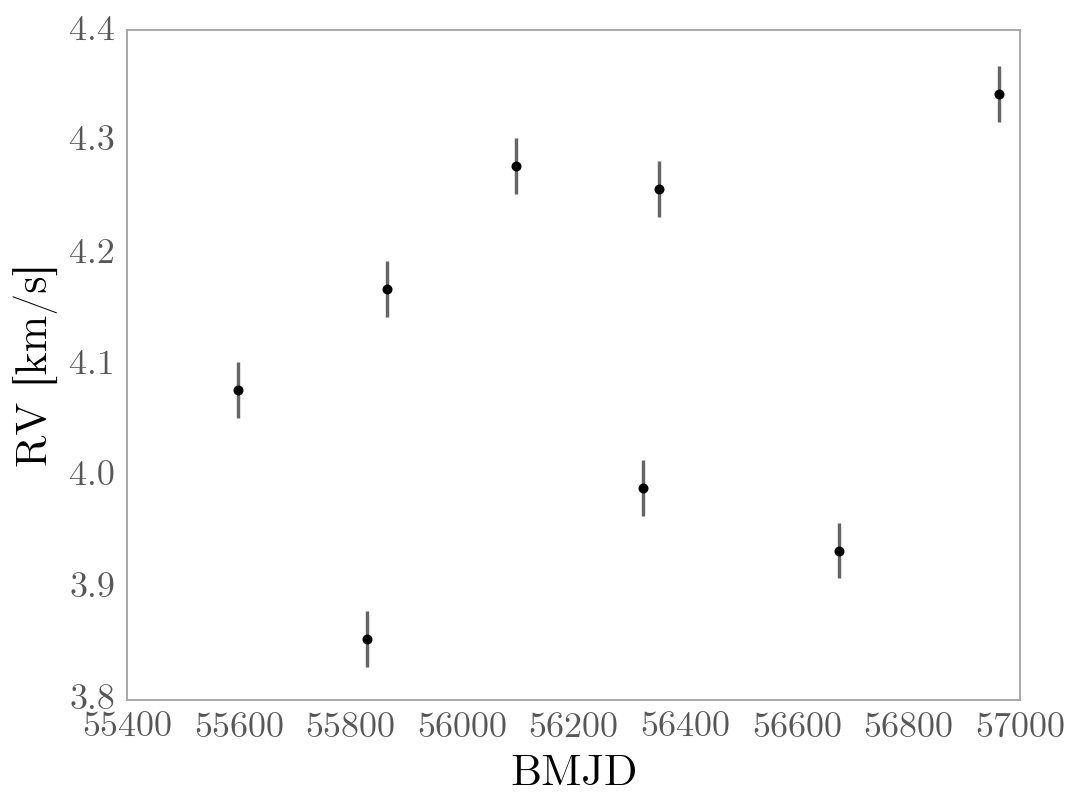

In [4]:
data = RVData(t=t, rv=rv, stddev=err)
ax = data.plot()
ax.set_xlabel("BMJD")
ax.set_ylabel("RV [km/s]")

In practice, you should use a very large range of periods, but for now we'll use a small range to make the sampling more efficient. Note that we also have to tell `TheJoker` that we want to infer the coefficients in a polynomial long-term velocity trend with two terms (constant + linear):

In [5]:
params = JokerParams(P_min=8*u.day, P_max=256*u.day, 
                     trend=PolynomialVelocityTrend(n_terms=2))

We again run using `multiprocessing`, so we have to create a `schwimmbad.MultiPool` instance to pass in to `TheJoker`. We only need the pool to do the rejection sampling, so we'll use a context manager to make sure the worker processes are all cleaned up:

_Warning: the cell below takes about 10 minutes to run on a machine with 4 cores_

In [6]:
%%time
with schwimmbad.MultiPool() as pool:
    joker = TheJoker(params, pool=pool, random_state=rnd)
    samples = joker.rejection_sample(data, n_prior_samples=1000000)

/Users/adrian/anaconda/envs/thejoker-dev/lib/python3.5/site-packages/thejoker-0.1.dev358-py3.5.egg/thejoker/celestialmechanics/celestialmechanics.py:100: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)
  "number of iterations ({})".format(maxiter), RuntimeWarning)
/Users/adrian/anaconda/envs/thejoker-dev/lib/python3.5/site-packages/thejoker-0.1.dev358-py3.5.egg/thejoker/celestialmechanics/celestialmechanics.py:100: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)
  "number of iterations ({})".format(maxiter), RuntimeWarning)
/Users/adrian/anaconda/envs/thejoker-dev/lib/python3.5/site-packages/thejoker-0.1.dev358-py3.5.egg/thejoker/celestialmechanics/celestialmechanics.py:100: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)
  "number of iterations ({})".format(maxiter), RuntimeWarning)
/Users/adrian/anaconda/envs/thejoker-dev/lib/python3.5/sit

INFO: 21 good samples after rejection sampling [thejoker.sampler.sampler]
CPU times: user 6.09 s, sys: 709 ms, total: 6.79 s
Wall time: 7min 53s


Now we'll plot the samples in two projections of the parameters (green lines are the true values of the parameters):

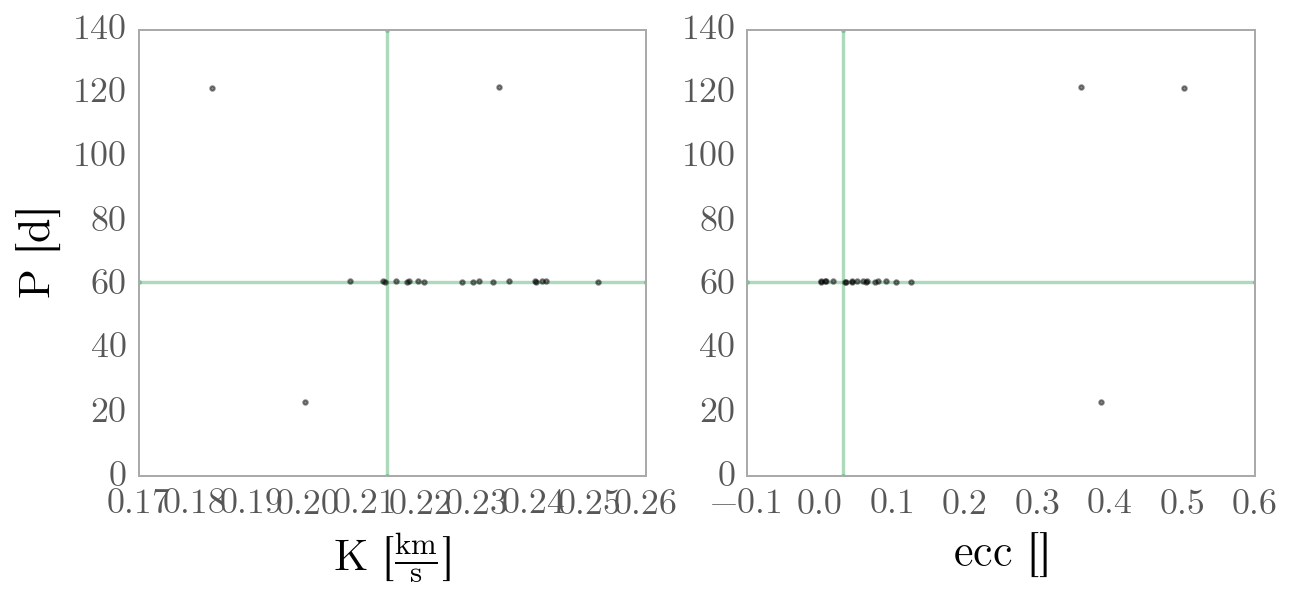

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

y_key = 'P'
y_unit = u.day
x_keys = ['K', 'ecc']
x_units = [u.km/u.s, u.one]

for ax,x_key,x_unit in zip(axes, x_keys, x_units):
    ax.scatter(samples[x_key].to(x_unit).value, 
               samples[y_key].to(y_unit).value,
               marker='.', color='k', alpha=0.45)
    ax.set_xlabel(r"{} [{}]".format(x_key, x_unit.to_string('latex')))
    
    ax.axvline(truth[x_key].to(x_unit).value, 
               zorder=-100, color='#31a354', alpha=0.4)
    ax.axhline(truth[y_key].to(y_unit).value, 
               zorder=-100, color='#31a354', alpha=0.4)
    
axes[0].set_ylabel(r"{} [{}]".format(y_key, y_unit.to_string('latex')))

Here are the velocity trend parameters:

(1e-05, 0.001)

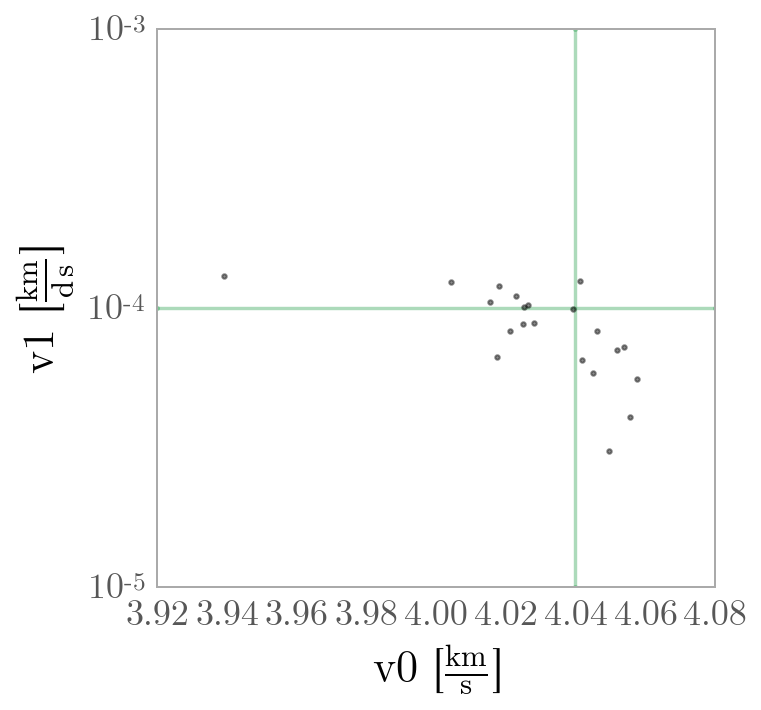

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x_key = 'v0'
x_unit = u.km/u.s
y_key = 'v1'
y_unit = u.km/u.s/u.day

# shift y intercept at t=0 (what we used to generate) to intercept at the data epoch
x_truth = (truth['v0'] + truth['v1']*(data.t_offset*u.day)).to(x_unit).value

ax.scatter(samples[x_key].to(x_unit).value, samples[y_key].to(y_unit).value,
           marker='.', color='k', alpha=0.45)
ax.set_xlabel(r"{} [{}]".format(x_key, x_unit.to_string('latex')))

ax.axvline(x_truth, zorder=-100, color='#31a354', alpha=0.4)
ax.axhline(truth[y_key].to(y_unit).value, 
           zorder=-100, color='#31a354', alpha=0.4)

ax.set_ylabel(r"{} [{}]".format(y_key, y_unit.to_string('latex')))
ax.set_yscale('log')
ax.set_ylim(1E-5, 1E-3)

And here we'll plot RV curves for the posterior samples over the data:

/Users/adrian/anaconda/envs/thejoker-dev/lib/python3.5/site-packages/thejoker-0.1.dev358-py3.5.egg/thejoker/celestialmechanics/celestialmechanics.py:100: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)
  "number of iterations ({})".format(maxiter), RuntimeWarning)


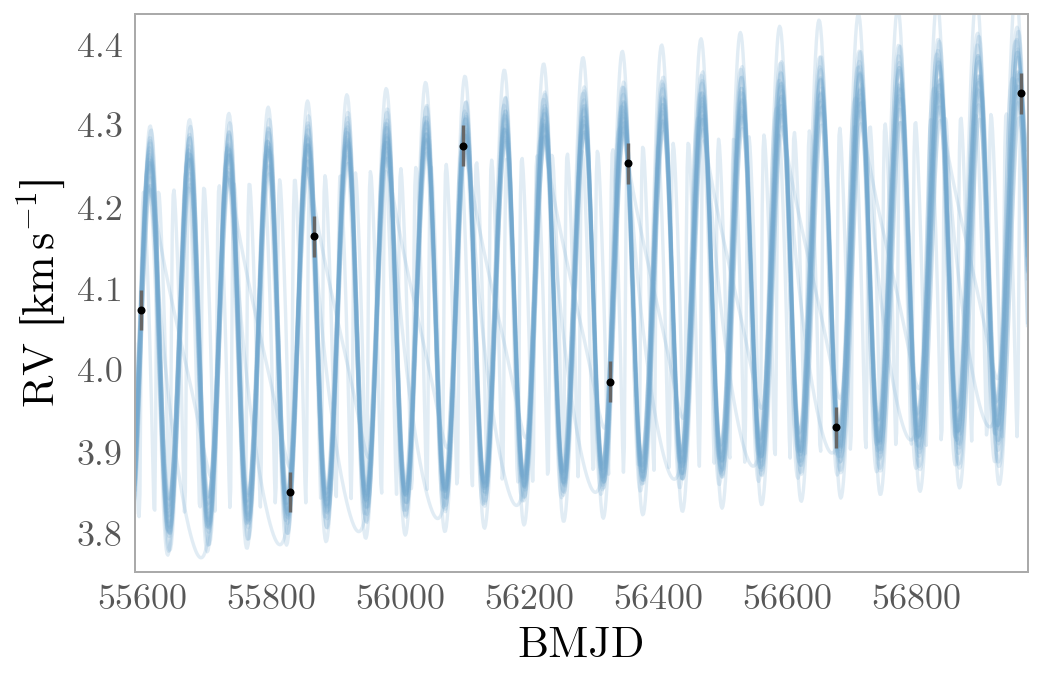

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,5)) # doctest: +SKIP
t_grid = np.linspace(data.t.mjd.min()-10, data.t.mjd.max()+10, 1024)
fig = plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
                     plot_kwargs=dict(color='#74a9cf', zorder=-100), trend_t_offset=data.t_offset)